In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.profile_models as profile_models
import model.profile_performance as profile_performance
import feature.util as feature_util
import feature.make_profile_dataset as make_profile_dataset
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

### Define paths for the model and data of interest

In [21]:
# Define the paths to the files and model, and some constants
files_spec_path = "/users/amtseng/att_priors/data/processed/ENCODE/profile/config/SPI1/SPI1_training_paths.json"
model_path = "/users/amtseng/att_priors/models/trained_models/profile_models/SPI1_prior_attdecay/1/model_ckpt_epoch_7.pt"

reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
input_length = 1346
profile_length = 1000
num_tasks = 4

In [3]:
# Extract the file specs
with open(files_spec_path, "r") as f:
    files_spec = json.load(f)
peaks_bed = files_spec["val_peak_beds"][0]  # First peaks BED, arbitrarily
profile_hdf5 = files_spec["profile_hdf5"]

In [22]:
# Import the model
model = model_util.restore_model(profile_models.ProfileTFBindingPredictor, model_path)
model.eval()
torch.set_grad_enabled(False)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device) 

### Data preparation
Use classes from `make_profile_dataset` to prepare positive and negative inputs.

In [7]:
# Maps coordinates to 1-hot encoded sequence
coords_to_seq = feature_util.CoordsToSeq(reference_fasta, center_size_to_use=input_length)

# Maps coordinates to profiles
coords_to_vals = make_profile_dataset.CoordsToVals(profile_hdf5, profile_length)

# Maps many coordinates to inputs sequences and profiles for the network
def coords_to_network_inputs(coords):
    input_seq = coords_to_seq(coords)
    profs = coords_to_vals(coords)
    return input_seq, np.swapaxes(profs, 1, 2)

### Predicting and plotting profiles

In [8]:
# Import set of positive peaks
pos_coords_table = pd.read_csv(peaks_bed, sep="\t", header=None, compression="gzip")

# Negative coordinate sampling
neg_coord_sampler = make_profile_dataset.GenomeIntervalSampler(chrom_sizes, input_length)

In [9]:
def predict_coords(coords):
    """
    Fetches the necessary data from the given coordinate and runs it through the
    network. Returns the network predictions AND the true values from the dataset.
    The returned profiles are in terms of raw counts, and the returned counts are
    also raw. Returned values are all NumPy arrays.
    """
    input_seqs, profiles = coords_to_network_inputs(coords)
    
    input_seqs = model_util.place_tensor(torch.tensor(input_seqs)).float()
    profiles = model_util.place_tensor(torch.tensor(profiles)).float()

    true_profs = profiles[:, :num_tasks, :, :]
    cont_profs = profiles[:, num_tasks:, :, :]

    # Run through the model
    logit_pred_profs, log_pred_counts = model(input_seqs, cont_profs)
    
    # Convert logit profile predictions to probabilities
    log_pred_profs = profile_models.profile_logits_to_log_probs(logit_pred_profs, axis=2)
    
    # Add true profiles to get true counts
    true_counts = torch.sum(true_profs, dim=2)
    
    return log_pred_profs.cpu().numpy(), log_pred_counts.cpu().numpy(), true_profs.cpu().numpy(), true_counts.cpu().numpy()

In [10]:
def plot_profiles(pred_profs, true_profs, title=None):
    """
    Plots the given profiles.
    Both arguments should be T x O x 2 NumPy arrays, where the subarrays are the
    tracks for the plus and minus strand, for each task.
    If `normalize` is True, normalize the profiles to be probabilities (i.e.
    each track sums to 1)
    """
    pred_profs, true_profs = np.squeeze(pred_profs), np.squeeze(true_profs)
    num_tasks, prof_length = pred_profs.shape[0], pred_profs.shape[1]
    fig, ax = plt.subplots(num_tasks, figsize=(15, 20))
    for i in range(num_tasks):
        ax[i].plot(true_profs[i,:,0], color="royalblue", alpha=0.5)
        ax[i].plot(-true_profs[i,:,1], color="goldenrod", alpha=0.5)
        ax[i].plot(pred_profs[i,:,0], color="darkslateblue")
        ax[i].plot(-pred_profs[i,:,1], color="darkorange")
    if title:
        fig.suptitle(title)

### View predictions

In [ ]:
# Sample some positive coordinates
pos_coords_table.sample(10)

In [ ]:
# Sample some negative coordinates
neg_coord_sampler.sample_intervals(10)

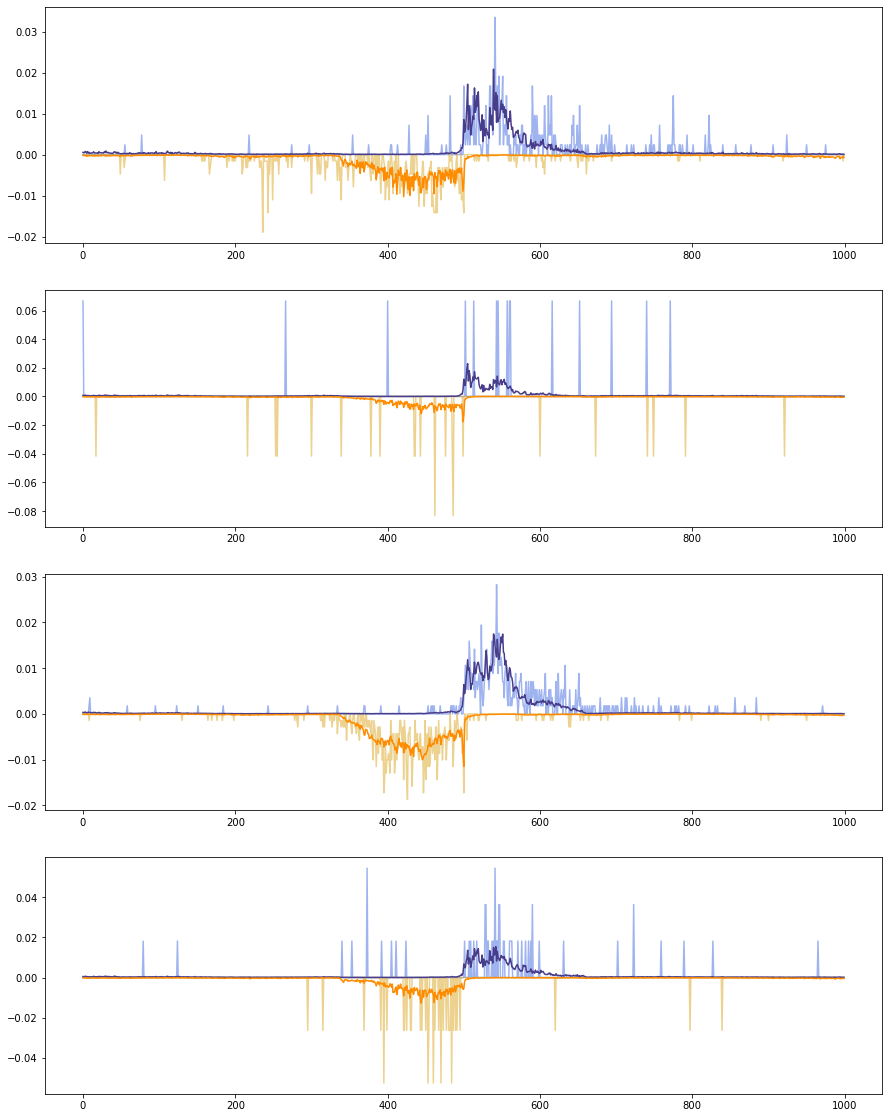

In [17]:
log_pred_profs, log_pred_counts, true_profs, true_counts = predict_coords([("chr7", 35728849, 35729849)])
pred_prof_probs = np.exp(log_pred_profs)
true_prof_probs = true_profs / np.sum(true_profs, axis=2, keepdims=True)
plot_profiles(pred_prof_probs, true_prof_probs)

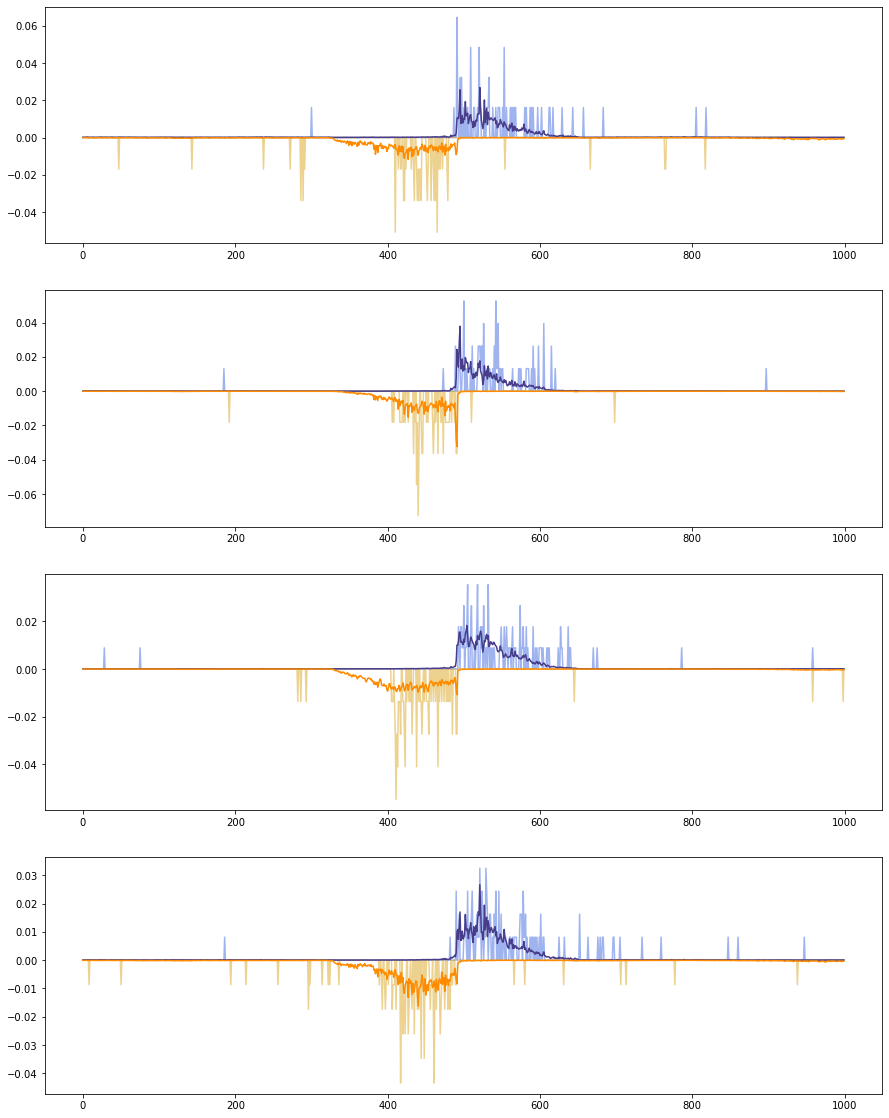

In [18]:
log_pred_profs, log_pred_counts, true_profs, true_counts = predict_coords([("chr21", 35867730, 35868730)])
pred_prof_probs = np.exp(log_pred_profs)
true_prof_probs = true_profs / np.sum(true_profs, axis=2, keepdims=True)
plot_profiles(pred_prof_probs, true_prof_probs)

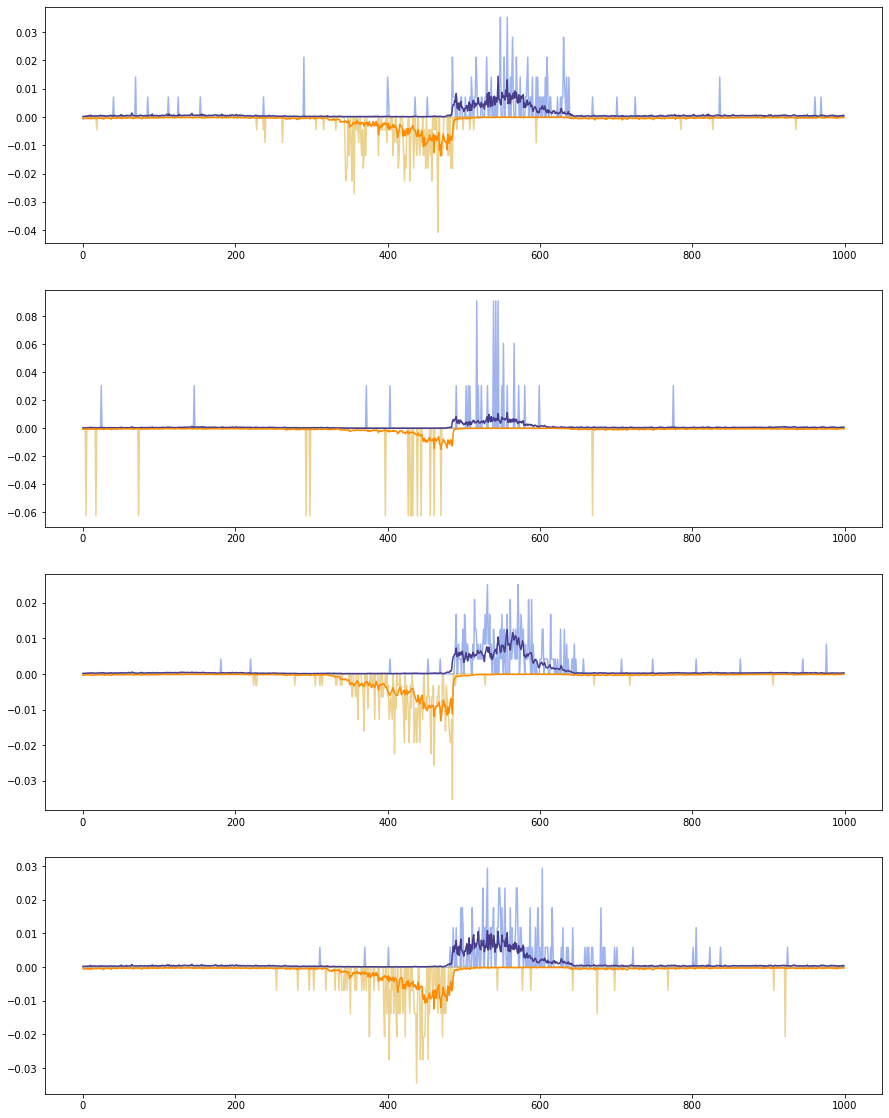

In [19]:
log_pred_profs, log_pred_counts, true_profs, true_counts = predict_coords([("chr8", 9551821, 9552821)])
pred_prof_probs = np.exp(log_pred_profs)
true_prof_probs = true_profs / np.sum(true_profs, axis=2, keepdims=True)
plot_profiles(pred_prof_probs, true_prof_probs)

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


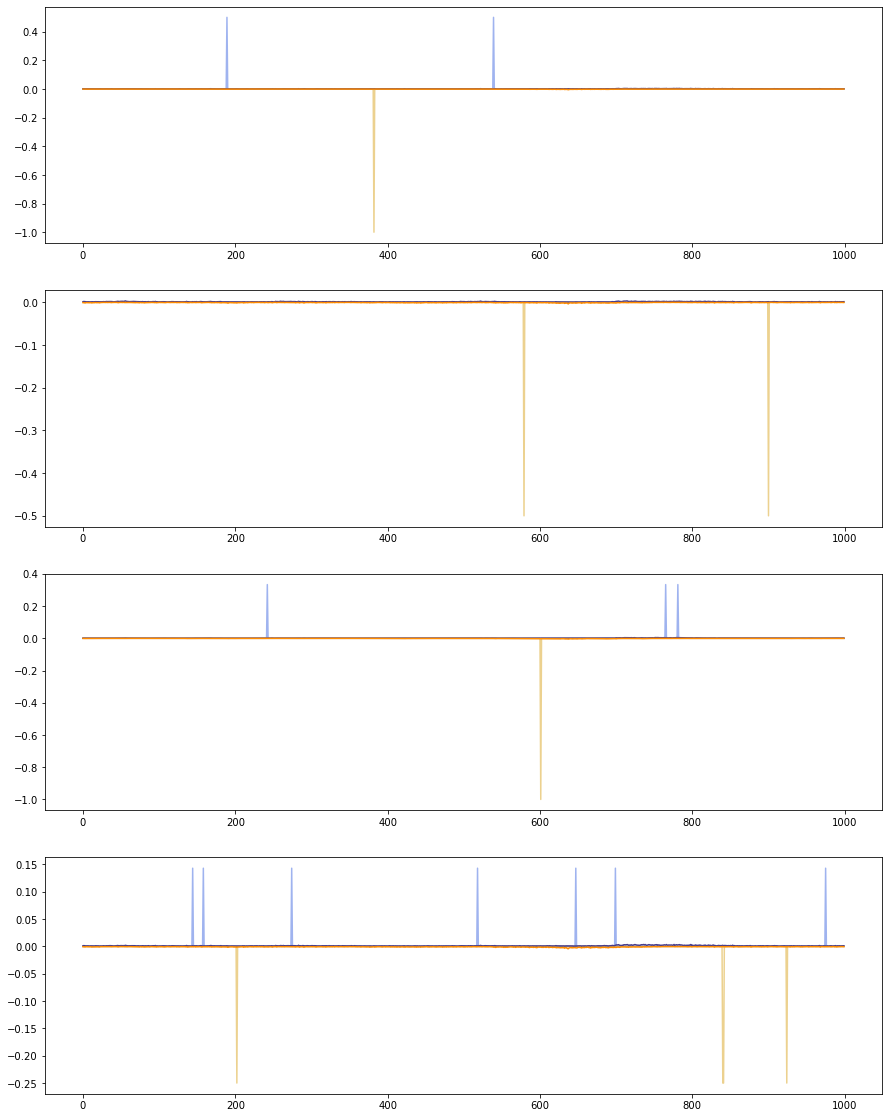

In [20]:
log_pred_profs, log_pred_counts, true_profs, true_counts = predict_coords([("chr2", 1000000, 1001000)])
pred_prof_probs = np.exp(log_pred_profs)
true_prof_probs = true_profs / np.sum(true_profs, axis=2, keepdims=True)
plot_profiles(pred_prof_probs, true_prof_probs)